In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/MyDrive/Cost_of_ship.zip"

In [ ]:
import regex as re
import nltk
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
import numpy as np
from sklearn.metrics import mean_squared_error as MSE, r2_score
from scipy.stats import skew,kurtosis,zscore
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Model

In [ ]:
df = pd.read_csv("dataset/train.csv")

In [ ]:
df.head(2)

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96


In [ ]:
df["Cost"] = df['Cost'].abs()

In [ ]:
df["Cost"] = np.log(df["Cost"])


In [ ]:
df["Cost"].skew()

1.7632204176472368

In [ ]:
df.describe()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,Cost
count,5750.000000,6125.000000,5916.000000,5.913000e+03,6500.00000,6500.000000,6500.000000
mean,0.461850,21.766204,9.617647,4.006948e+05,1192.42009,37.407174,6.593047
std,0.265781,11.968192,5.417000,2.678081e+06,8819.61675,26.873519,1.652754
min,0.000000,3.000000,2.000000,3.000000e+00,3.00000,10.000000,4.455161
25%,0.240000,12.000000,6.000000,5.030000e+02,5.23000,16.700000,5.424047
50%,0.450000,20.000000,8.000000,3.102000e+03,8.02500,23.505000,6.127208
75%,0.680000,30.000000,12.000000,3.645600e+04,89.47000,57.905000,7.219841
max,1.000000,73.000000,50.000000,1.179279e+08,382385.67000,99.980000,16.226360


In [ ]:
df.skew()

Artist Reputation       0.141363
Height                  0.594041
Width                   1.546702
Weight                 21.556174
Price Of Sculpture     22.206823
Base Shipping Price     0.918102
Cost                    1.763220
dtype: float64

In [ ]:
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'],format='%m/%d/%y')

In [ ]:
df['S_month'] = df['Scheduled Date'].dt.month
df['S_year'] = df['Scheduled Date'].dt.year
df['S_day'] = df['Scheduled Date'].dt.day

In [ ]:
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'],format='%m/%d/%y')

In [ ]:
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'],format='%m/%d/%y')

In [ ]:
df['D_month'] = df['Delivery Date'].dt.month
df['D_year'] = df['Delivery Date'].dt.year
df['D_day'] = df['Delivery Date'].dt.day

In [ ]:
df.head(2)

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,S_month,S_year,S_day,D_month,D_year,D_day
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,2015-06-07,2015-06-03,"New Michelle, OH 50777",5.646471,6,2015,7,6,2015,3
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,2017-03-06,2017-03-05,"New Michaelport, WY 12072",5.074924,3,2017,6,3,2017,5


In [ ]:
df.isnull().sum()

Customer Id                 0
Artist Name                 0
Artist Reputation         750
Height                    375
Width                     584
Weight                    587
Material                  764
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1392
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                        0
S_month                     0
S_year                      0
S_day                       0
D_month                     0
D_year                      0
D_day                       0
dtype: int64

In [ ]:
df['Transport'].fillna("missingTransport",inplace=True)
df['Material'].fillna("missingMaterial",inplace=True)
df['Remote Location'].fillna("missingRemoteLocation",inplace=True)

In [ ]:
'''df['Artist Reputation'].fillna(value=df['Artist Reputation'].median(), inplace=True)
df['Height'].fillna(value=df['Height'].median(), inplace=True)
df['Weight'].fillna(value=df['Weight'].median(), inplace=True)
df['Width'].fillna(value=df['Width'].median(), inplace=True)'''

"df['Artist Reputation'].fillna(value=df['Artist Reputation'].median(), inplace=True)\ndf['Height'].fillna(value=df['Height'].median(), inplace=True)\ndf['Weight'].fillna(value=df['Weight'].median(), inplace=True)\ndf['Width'].fillna(value=df['Width'].median(), inplace=True)"

In [ ]:
df.isnull().sum()

Customer Id                0
Artist Name                0
Artist Reputation        750
Height                   375
Width                    584
Weight                   587
Material                   0
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                  0
Fragile                    0
Customer Information       0
Remote Location            0
Scheduled Date             0
Delivery Date              0
Customer Location          0
Cost                       0
S_month                    0
S_year                     0
S_day                      0
D_month                    0
D_year                     0
D_day                      0
dtype: int64

In [ ]:
y = df.Cost
df = df.drop(['Cost','Customer Id'],1)

In [ ]:
#creating features
med_price_per_mat_dict = df.groupby('Material')['Price Of Sculpture'].median().to_dict()
med_price_per_trans_dict = df.groupby('Transport')['Price Of Sculpture'].mean().to_dict()

In [ ]:
df_text = df[['Material','International','Express Shipment','Installation Included','Customer Location','Remote Location','Customer Information','Fragile','Transport']]

In [ ]:
df_text.head(2)

,Material,International,Express Shipment,Installation Included,Customer Location,Remote Location,Customer Information,Fragile,Transport
0,Brass,Yes,Yes,No,"New Michelle, OH 50777",No,Working Class,No,Airways
1,Brass,No,No,No,"New Michaelport, WY 12072",No,Working Class,No,Roadways


In [ ]:
df_num = df.drop(['Artist Name','Material','International','Express Shipment','Installation Included','Customer Location','Remote Location','Customer Information','Fragile','Transport'],1)

In [ ]:

df_num['med_price_per_mat'] = df['Material'].map(med_price_per_mat_dict )
df_num['med_price_per_trans'] = df['Transport'].map(med_price_per_trans_dict)

In [ ]:
df_num['unitPrice'] = df_num['Price Of Sculpture'] / df_num['Weight']
df_num['timeDelta'] = (df['Scheduled Date'] - df['Delivery Date']).dt.days
df_num['unitPrice2'] = df_num['Price Of Sculpture'] / (df_num['Height']*df_num['Weight'])
df_num['unitPrice3'] = df_num['Base Shipping Price'] / (df_num['Height']*df_num['Weight'])
#df_num['unitPrice4'] = df_num['Price Of Sculpture'] * df_num['Artist Reputation']
df = df.drop(['Scheduled Date','Delivery Date'],1)
df_num = df_num.drop(['Scheduled Date','Delivery Date'],1)

In [ ]:
'''conditions = [
    (df_num['timeDelta'] <= 0),
    (df_num['timeDelta'] > 0)
    ]

values = [0,1]
df_num['late'] = np.select(conditions, values)
df_num = df_num.drop(['timeDelta'],1)'''

"conditions = [\n    (df_num['timeDelta'] <= 0),\n    (df_num['timeDelta'] > 0)\n    ]\n\nvalues = [0,1]\ndf_num['late'] = np.select(conditions, values)\ndf_num = df_num.drop(['timeDelta'],1)"

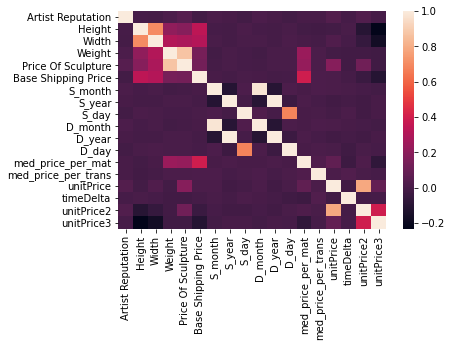

In [ ]:
sns.heatmap(df_num.corr());

In [ ]:
df_num.head(2)

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,S_month,S_year,S_day,D_month,D_year,D_day,med_price_per_mat,med_price_per_trans,unitPrice,timeDelta,unitPrice2,unitPrice3
0,0.26,17.0,6.0,4128.0,13.91,16.27,6,2015,7,6,2015,3,19.96,1218.768762,0.003370,4,0.000198,0.000232
1,0.28,3.0,3.0,61.0,6.83,15.00,3,2017,6,3,2017,5,19.96,1277.621689,0.111967,1,0.037322,0.081967


In [ ]:
df_text['main'] = df_text[df_text.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

df_text.main.head(3)

0    Brass,Yes,Yes,No,New Michelle, OH 50777,No,Wor...
1    Brass,No,No,No,New Michaelport, WY 12072,No,Wo...
2    Clay,No,No,No,Bowmanshire, WA 19241,Yes,Workin...
Name: main, dtype: object

In [ ]:
X_text = df_text.main

In [ ]:
import regex as re
model = []
for i in range(0, df.shape[0]):
    data = re.sub(r'\W', ' ', str(X_text[i]))
    data = data.lower()
    data = re.sub(r'^br$', ' ', data)
    data = re.sub(r'\s+br\s+',' ',data)
    data = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", data)
    data = re.sub(r'\s+[a-z]\s+', ' ',data)
    data = re.sub(r'^b\s+', '', data)
    data = re.sub(r'\s+', ' ', data)
    model.append(data)   

In [ ]:
model[1]

'brass no no no new michaelport wy no working class no roadways'

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#vector = TfidfVectorizer(max_features = 20, min_df = 1, max_df = 0.99, stop_words = stopwords.words('english'))
vector = CountVectorizer(max_features = 50)
X_text = vector.fit_transform(model).toarray()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df_num = scaler.fit_transform(df_num,1)
df_num

array([[2.60000000e-01, 2.00000000e-01, 8.33333333e-02, ...,
        1.00000000e+00, 7.88000528e-05, 1.26572869e-04],
       [2.80000000e-01, 0.00000000e+00, 2.08333333e-02, ...,
        6.25000000e-01, 1.51620199e-02, 4.47500675e-02],
       [7.00000000e-02, 7.14285714e-02, 6.25000000e-02, ...,
        6.25000000e-01, 1.06113743e-03, 6.09875147e-03],
       ...,
       [6.80000000e-01, 2.28571429e-01, 1.25000000e-01, ...,
        6.25000000e-01, 2.50354332e-04, 5.08108256e-04],
       [2.00000000e-02, 4.28571429e-01, 1.45833333e-01, ...,
        2.50000000e-01, 2.66767272e-05, 9.05729353e-07],
       [1.80000000e-01, 3.85714286e-01, 2.29166667e-01, ...,
        2.50000000e-01, 1.64507123e-05, 4.10003628e-05]])

In [ ]:
X_num = df_num

In [ ]:
X = np.concatenate((X_text,X_num),axis = 1)
X

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 7.88000528e-05, 1.26572869e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.25000000e-01, 1.51620199e-02, 4.47500675e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.25000000e-01, 1.06113743e-03, 6.09875147e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.25000000e-01, 2.50354332e-04, 5.08108256e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.50000000e-01, 2.66767272e-05, 9.05729353e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.50000000e-01, 1.64507123e-05, 4.10003628e-05]])

In [ ]:
X1 = pd.DataFrame(X)

# Prediction

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(n_jobs = -1, random_state = 42, n_estimators = 1, verbose = 1)

In [ ]:
regr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [ ]:
import numpy as np

pred1 = regr.predict(X_test) 
rmse = np.sqrt(MSE(y_test, pred1)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.461830


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
r2_score(y_test,pred1)*100

91.84109800848965

In [ ]:
import lightgbm as lgb
train = lgb.Dataset(X_train, label=y_train)
test = lgb.Dataset(X_test, label=y_test)

In [ ]:
param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.01, 
         'num_iterations': 10000,
         'min_data_in_leaf': 10,
         'bagging_fraction': 0.99,
         'bagging_freq': 2,
         'bagging_seed': 3,
         'feature_fraction': 0.99,
         'feature_fraction_seed': 5,
         'early_stopping_round': 1000,
         'max_bin': 500
         }

In [ ]:
gbm = lgb.LGBMRegressor(**param)

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds = 100)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.60468	valid_0's l1: 1.20901
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's rmse: 1.58952	valid_0's l1: 1.19794
[3]	valid_0's rmse: 1.57467	valid_0's l1: 1.18712
[4]	valid_0's rmse: 1.55985	valid_0's l1: 1.17625
[5]	valid_0's rmse: 1.54531	valid_0's l1: 1.16574
[6]	valid_0's rmse: 1.53203	valid_0's l1: 1.15625
[7]	valid_0's rmse: 1.5177	valid_0's l1: 1.1458
[8]	valid_0's rmse: 1.50353	valid_0's l1: 1.1354
[9]	valid_0's rmse: 1.48952	valid_0's l1: 1.12519
[10]	valid_0's rmse: 1.47573	valid_0's l1: 1.11513
[11]	valid_0's rmse: 1.4619	valid_0's l1: 1.10505
[12]	valid_0's rmse: 1.44827	valid_0's l1: 1.09509
[13]	valid_0's rmse: 1.43475	valid_0's l1: 1.0852
[14]	valid_0's rmse: 1.4214	valid_0's l1: 1.07536
[15]	valid_0's rmse: 1.40823	valid_0's l1: 1.06575
[16]	valid_0's rmse: 1.39595	valid_0's l1: 1.0564
[17]	valid_0's rmse: 1.38303	valid_0's l1: 1.04692
[18]	valid_0's rmse: 1.37051	valid_0's l1: 1.03768
[19]	valid_0's rmse: 1.35793	valid

LGBMRegressor(bagging_fraction=0.99, bagging_freq=2, bagging_seed=3,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, early_stopping_round=1000,
              feature_fraction=0.99, feature_fraction_seed=5,
              importance_type='split', learning_rate=0.01, max_bin=500,
              max_depth=-1, metric='l2_root', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=10000, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, ...)

In [ ]:
pred1 = gbm.predict(X_test, num_iteration = gbm.best_iteration_) 
rmse = np.sqrt(MSE(y_test, pred1)) 
print("RMSE : % f" %(rmse)) 
print(r2_score(y_test,pred1)*100) #97.34662954908498 0.263369

RMSE :  0.265374
97.30607957924981


# Test

In [ ]:
df = pd.read_csv("dataset/test.csv")

In [ ]:
df1 = df[['Customer Id']]

In [ ]:
df.head(2)


,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location
0,fffe3400310033003300,James Miller,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,07/03/17,07/06/17,"Santoshaven, IA 63481"
1,fffe3600350035003400,Karen Vetrano,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,05/02/16,05/02/16,"Ericksonton, OH 98253"


In [ ]:
df.describe()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price
count,3278.000000,3381.000000,3359.000000,3.351000e+03,3500.000000,3500.000000
mean,0.463279,21.275067,9.371837,3.749665e+05,1059.608646,36.352909
std,0.272287,11.689805,5.231695,2.517256e+06,7409.348267,26.299318
min,0.000000,3.000000,2.000000,4.000000e+00,3.000000,10.000000
25%,0.230000,12.000000,6.000000,4.895000e+02,5.160000,16.870000
50%,0.450000,20.000000,8.000000,2.929000e+03,7.120000,23.055000
75%,0.680000,29.000000,12.000000,3.340650e+04,81.195000,55.742500
max,1.000000,65.000000,48.000000,6.459500e+07,227254.240000,99.980000


In [ ]:
df.skew()

Artist Reputation       0.140351
Height                  0.584389
Width                   1.629911
Weight                 14.819304
Price Of Sculpture     17.347316
Base Shipping Price     1.000954
dtype: float64

In [ ]:
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'],format='%m/%d/%y')

In [ ]:
df['S_month'] = df['Scheduled Date'].dt.month
df['S_year'] = df['Scheduled Date'].dt.year
df['S_day'] = df['Scheduled Date'].dt.day

In [ ]:
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'],format='%m/%d/%y')

In [ ]:
df['D_month'] = df['Delivery Date'].dt.month
df['D_year'] = df['Delivery Date'].dt.year
df['D_day'] = df['Delivery Date'].dt.day

In [ ]:
#df = df.drop(['Scheduled Date','Delivery Date'],1)

In [ ]:
df.head(2)

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,S_month,S_year,S_day,D_month,D_year,D_day
0,fffe3400310033003300,James Miller,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,2017-07-03,2017-07-06,"Santoshaven, IA 63481",7,2017,3,7,2017,6
1,fffe3600350035003400,Karen Vetrano,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,2016-05-02,2016-05-02,"Ericksonton, OH 98253",5,2016,2,5,2016,2


In [ ]:
df.isnull().sum()

Customer Id                0
Artist Name                0
Artist Reputation        222
Height                   119
Width                    141
Weight                   149
Material                   0
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                232
Fragile                    0
Customer Information       0
Remote Location            0
Scheduled Date             0
Delivery Date              0
Customer Location          0
S_month                    0
S_year                     0
S_day                      0
D_month                    0
D_year                     0
D_day                      0
dtype: int64

In [ ]:
df['Transport'].fillna("missingTransport",inplace=True)
df['Material'].fillna("missingMaterial",inplace=True)
df['Remote Location'].fillna("missingRemoteLocation",inplace=True)

In [ ]:
df['Artist Reputation'].fillna(value=df['Artist Reputation'].median(), inplace=True)
df['Height'].fillna(value=df['Height'].median(), inplace=True)
df['Weight'].fillna(value=df['Weight'].median(), inplace=True)
df['Width'].fillna(value=df['Width'].median(), inplace=True)

In [ ]:
df.isnull().sum()

Customer Id              0
Artist Name              0
Artist Reputation        0
Height                   0
Width                    0
Weight                   0
Material                 0
Price Of Sculpture       0
Base Shipping Price      0
International            0
Express Shipment         0
Installation Included    0
Transport                0
Fragile                  0
Customer Information     0
Remote Location          0
Scheduled Date           0
Delivery Date            0
Customer Location        0
S_month                  0
S_year                   0
S_day                    0
D_month                  0
D_year                   0
D_day                    0
dtype: int64

In [ ]:

df = df.drop(['Customer Id'],1)

In [ ]:
df_text = df[['Material','International','Express Shipment','Installation Included','Customer Location','Remote Location','Customer Information','Fragile','Transport']]

In [ ]:
df_text.head(2)

,Material,International,Express Shipment,Installation Included,Customer Location,Remote Location,Customer Information,Fragile,Transport
0,Wood,Yes,Yes,No,"Santoshaven, IA 63481",No,Working Class,No,Airways
1,Clay,No,No,No,"Ericksonton, OH 98253",No,Working Class,Yes,Roadways


In [ ]:
df_num = df.drop(['Artist Name','Material','International','Express Shipment','Installation Included','Customer Location','Remote Location','Customer Information','Fragile','Transport'],1)

In [ ]:

df_num['med_price_per_mat'] = df['Material'].map(med_price_per_mat_dict )
df_num['med_price_per_trans'] = df['Transport'].map(med_price_per_trans_dict)

In [ ]:
df_num['unitPrice'] = df_num['Price Of Sculpture'] / df_num['Weight']
df_num['timeDelta'] = (df['Scheduled Date'] - df['Delivery Date']).dt.days
df_num['unitPrice2'] = df_num['Price Of Sculpture'] / (df_num['Height']*df_num['Weight'])
df_num['unitPrice3'] = df_num['Base Shipping Price'] / (df_num['Height']*df_num['Weight'])
df = df.drop(['Scheduled Date','Delivery Date'],1)
df_num = df_num.drop(['Scheduled Date','Delivery Date'],1)

In [ ]:
'''conditions = [
    (df_num['timeDelta'] <= 0),
    (df_num['timeDelta'] > 0)
    ]
    
values = [0,1]
df_num['late'] = np.select(conditions, values)
'''

"conditions = [\n    (df_num['timeDelta'] <= 0),\n    (df_num['timeDelta'] > 0)\n    ]\n    \nvalues = [0,1]\ndf_num['late'] = np.select(conditions, values)\n"

In [ ]:
df_num.head(2)

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,S_month,S_year,S_day,D_month,D_year,D_day,med_price_per_mat,med_price_per_trans,unitPrice,timeDelta,unitPrice2,unitPrice3
0,0.35,53.0,18.0,871.0,5.98,19.11,7,2017,3,7,2017,6,5.080,1218.768762,0.006866,-3,0.000130,0.000414
1,0.67,7.0,4.0,108.0,6.92,13.96,5,2016,2,5,2016,2,6.075,1277.621689,0.064074,0,0.009153,0.018466


In [ ]:
df_text['main'] = df_text[df_text.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

df_text.main.head(3)

0    Wood,Yes,Yes,No,Santoshaven, IA 63481,No,Worki...
1    Clay,No,No,No,Ericksonton, OH 98253,No,Working...
2    Aluminium,Yes,No,No,APO AP 83453,No,Working Cl...
Name: main, dtype: object

In [ ]:
X_text = df_text.main

In [ ]:
import regex as re
model = []
for i in range(0, df.shape[0]):
    data = re.sub(r'\W', ' ', str(X_text[i]))
    data = data.lower()
    data = re.sub(r'^br$', ' ', data)
    data = re.sub(r'\s+br\s+',' ',data)
    data = re.sub(r'\s+[a-z]\s+', ' ',data)
    data = re.sub(r'^b\s+', '', data)
    data = re.sub(r'\s+', ' ', data)
    model.append(data)   

In [ ]:
model[1]

'clay no no no ericksonton oh 98253 no working class yes roadways'

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#vector = TfidfVectorizer(max_features = 500, min_df = 1, max_df = 0.8, stop_words = stopwords.words('english'))
X_text = vector.transform(model).toarray()

In [ ]:
df_num = scaler.transform(df_num)
df_num

array([[3.50000000e-01, 7.14285714e-01, 3.33333333e-01, ...,
        1.25000000e-01, 5.08980498e-05, 2.26002669e-04],
       [6.70000000e-01, 5.71428571e-02, 4.16666667e-02, ...,
        5.00000000e-01, 3.71722574e-03, 1.00813115e-02],
       [6.10000000e-01, 4.28571429e-02, 6.25000000e-02, ...,
        2.50000000e-01, 2.95120573e-03, 1.27763725e-02],
       ...,
       [5.90000000e-01, 1.28571429e-01, 8.33333333e-02, ...,
        3.75000000e-01, 1.01261266e-04, 3.04130997e-04],
       [4.50000000e-01, 2.00000000e-01, 1.45833333e-01, ...,
        5.00000000e-01, 2.83791308e-04, 6.18987161e-04],
       [9.70000000e-01, 3.14285714e-01, 1.87500000e-01, ...,
        1.00000000e+00, 7.65518011e-05, 6.88804995e-07]])

In [ ]:
X_num = df_num

In [ ]:
X = np.concatenate((X_text,X_num),axis = 1)
X

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.25000000e-01, 5.08980498e-05, 2.26002669e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.00000000e-01, 3.71722574e-03, 1.00813115e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.50000000e-01, 2.95120573e-03, 1.27763725e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.75000000e-01, 1.01261266e-04, 3.04130997e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.00000000e-01, 2.83791308e-04, 6.18987161e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 7.65518011e-05, 6.88804995e-07]])

In [ ]:
X_xg = pd.DataFrame(X)

In [ ]:
#pred = gbm.predict(X)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
errgb = []
y_pred_totgb = []
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
fold = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
for train_index, test_index in fold.split(X1):
    i = i +1
    X_train, X_test = X1.loc[train_index], X1.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb =  XGBRegressor(max_depth = 25, 
                   learning_rate = 0.1, 
                   n_estimators = 300, 
                   silent = False, 
                   objective = 'reg:squarederror', 
                   booster = 'gbtree', 
                   n_jobs = 4, 
                   nthread = None, 
                   gamma = 0, 
                   min_child_weight = 1, 
                   max_delta_step = 0, 
                   subsample = 1, 
                   colsample_bytree = 1, 
                   colsample_bylevel = 1, 
                   reg_alpha = 0.95, 
                   reg_lambda = 1, 
                   scale_pos_weight = 1, 
                   base_score = 0.7, 
                   random_state = 42, 
                   verbose = 1,
                   seed=None)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    print(i,":","RMSE LGBM: ",  np.sqrt(MSE(y_test, y_pred)))
    print(i,":""R2 LGBM: ",  r2_score(y_test,y_pred)*100)
    print("*****************************")
    errgb.append(np.sqrt(MSE(y_test, y_pred)))
    p = gb.predict(X)
    y_pred_totgb.append(p)

In [ ]:
np.mean(errgb,0)

In [ ]:
gbm_final = np.mean(y_pred_totgb,0)
gbm_final = np.exp(gbm_final)

In [ ]:

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits = 10, shuffle=True, random_state=42)
i = 0
for train_index, test_index in fold.split(X1):
    i = i +1
    X_train, X_test = X1.loc[train_index], X1.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)
    y_pred_lgbm = lgbm.predict(X_test)
    print(i:,"RMSE LGBM: ",  np.sqrt(MSE(y_test, y_pred_lgbm)))
    print(i:"R2 LGBM: ",  r2_score(y_test,y_pred_lgbm)*100)
    print("*****************************")
    errlgb.append(np.sqrt(MSE(y_test, y_pred_lgbm)))
    p = lgbm.predict(X)
    y_pred_totlgb.append(p)

In [ ]:
np.mean(errlgb,0) #0.27851510974955973 #0.281964

In [ ]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final = np.exp(lgbm_final)
lgbm_final

array([   276.09009728,    267.60902411,    182.09192813, ...,
          539.747833  ,    243.53691203, 106000.4448843 ])

In [ ]:
data = {
        'index': df1['Customer Id'],
        'Cost': lgbm_final*0.99 + gbm_final*0.05} 

In [ ]:
df_sub = pd.DataFrame(data = data)

In [ ]:
df_sub.to_csv('result_hk.csv',index=False)

In [ ]:
df_sub.head(2)

,Customer Id,Cost
0,fffe3400310033003300,291.805920
1,fffe3600350035003400,276.579848
